# Finetune on experimental data
This notebook demonstrates how to finetune METL models on experimental data.

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import sys

# 1. Get the absolute path of the directory containing the current script.
#    This will be your '01_finetune_metl_global' folder.
current_dir = os.getcwd()

# 2. Get the parent directory of your current script's folder.
#    This will be the top-level 'metl' directory that contains both of your folders.
parent_dir = os.path.dirname(current_dir)

# 3. Construct the path to the sibling 'metl' repo's 'code' folder.
module_path = os.path.join(parent_dir, "metl", "code")

# 4. Add the module path to the system path so imports work.
if module_path not in sys.path:
    sys.path.append(module_path)

# You can add a print statement to confirm it's working correctly
print(f"Added to sys.path: {module_path}")

Added to sys.path: /home/oscar/projects/strucbio_projects/plm_md_modeling/metl/metl/code


# Acquire an experimental dataset

For demonstration purposes, this repository contains the [avGFP dataset](../data/dms_data/avgfp) from [Sarkisyan et al. (2016)](https://doi.org/10.1038/nature17995). 
See the [metl-pub](https://github.com/gitter-lab/metl-pub) repository to access the other experimental datasets we used in our preprint.
See the README in the [dms_data](../data/dms_data) directory for information about how to use your own experimental dataset. 

# Acquire a pretrained model
Pretrained METL models are available in the [metl-pretrained](https://github.com/gitter-lab/metl-pretrained) repository. You can use one of those, or you can pretrain your own METL model (see [pretraining.ipynb](pretraining.ipynb)). 

For demonstration purposes, we include a pretrained avGFP METL-Local model from the [metl-pretrained](https://github.com/gitter-lab/metl-pretrained) repository in the [pretrained_models](../pretrained_models) directory. This model is `METL-L-2M-3D-GFP` (UUID: `Hr4GNHws`).
It is the avGFP METL-Local source model we used for the analysis in our preprint.

We will show how to finetune this model using the [experimental avGFP dataset](../data/dms_data/avgfp).

# Training arguments

The script for finetuning on experimental data is [train_target_model.py](train_target_model.py). This script has a number of arguments you can view by uncommenting and running the below cell. There are additional arguments related to architecture that won't show up if you run the command, but you can view them in [models.py](../code/models.py) in the `TransferModel` class.

In [18]:
!python /home/oscar/projects/strucbio_projects/plm_md_modeling/metl/metl/code/train_target_model.py -h

/home/oscar/miniconda3/envs/metl/lib/python3.9/site-packages/pytorch_lightning/utilities/imports.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
usage: train_target_model.py [-h] [--seed SEED] [--early_stopping]
                             [--es_monitor {train,val,auto}]
                             [--es_patience ES_PATIENCE]
                             [--es_min_delta ES_MIN_DELTA]
                             [--ckpt_monitor {train,val,auto}] [--finetuning]
                             [--finetuning_strategy {backbone,extract}]
                             [--unfreeze_backbone_at_epoch UNFREEZE_BACKBONE_AT_EPOCH]
                             [--train_bn] [--backbone_always_align_lr]
                             [--backbone_initial_ratio_lr BACKBONE_INITIAL_RATI

We set up finetuning arguments for this example in [finetune_avgfp_local.txt](../args/pretrain_avgfp_local.txt) in the [args](../args) directory. This argument file can be used directly with [train_target_model.py](train_target_model.py) by calling the command `!python code/train_target_model.py @args/finetune_avgfp_local.txt` (we do this in the next section).

Uncomment and run the cell below to view the contents of the argument file. The sections below will walk through and explain the key arguments.

In [4]:
# with open("args/finetune_avgfp_local.txt", "r") as file:
#     contents = file.read()
#     print(contents)

## Dataset arguments


Specify the dataset name and the train/val/test split. The dataset must be defined in [datasets.yml](../data/dms_data/datasets.yml). For demonstration purposes, we are using one of the reduced dataset size splits with a dataset size of 160 (train size of 128).
```
--ds_name
avgfp
--split_dir
data/dms_data/avgfp/splits/resampled/resampled_ds160_val0.2_te0.1_w1abc2f4e9a64_s1_r8099/resampled_ds160_val0.2_te0.1_w1abc2f4e9a64_s1_r8099_rep_0
```

Specify the names of the train, validation, and test set files in the split directory. Using "auto" for the test_name will select the super test set ("stest.txt") if it exists in the split directory, otherwise it will use the standard test set ("test.txt").

```
--train_name
train
--val_name
val
--test_name
test
```

The name of the target column in the dataset dataframe. The model will be finetuned to predict the score in this column.

```
--target_names
score
```

The METL-Local model we are finetuning uses 3D structure-based relative position embeddings, so we need to specify the PDB filename. This PDB file is in the [data/pdb_files](../data/pdb_files) directory, which the script checks by default, so there is no need to specify the full path. You can also just specify "auto" to use the PDB file defined for this dataset in [datasets.yml](../data/dms_data/datasets.yml).

```
--pdb_fn
1gfl_cm.pdb
```

## Network architecture arguments

For finetuning, we implemented a special model `transfer_model` that handles pretrained checkpoints with top nets. 
```
--model_name
transfer_model
```

The pretrained checkpoint can be a PyTorch checkpoint (.pt file) downloaded from the [metl-pretrained](https://github.com/gitter-lab/metl-pretrained) repository or a PyTorch Lightning checkpoint (.ckpt file) obtained from pretraining a model with this repository.
```
--pretrained_ckpt_path
pretrained_models/Hr4GNHws.pt
```

The backbone cutoff determines where to cutoff the pretrained model and place the new prediction head. For METL-Local models, we recommend backbone cutoff -1, and for METL-Global models we recommend backbone cutoff -2. 

```
--backbone_cutoff
-1
```

The remaining arguments determine the encoding, which should be set to `int_seqs`, whether to use dropout after the backbone cutoff, and the architecture of the new top net. You can leave these values as-is to match what we did for the preprint.

```
--encoding
int_seqs
--dropout_after_backbone
--dropout_after_backbone_rate
0.5
--top_net_type
linear
```

## Finetuning strategy arguments

We implemented a dual-phase finetuning strategy. During the first phase, the backbone weights are frozen and only the top net is trained. During the second phase, all the network weights are unfrozen and trained at a reduced learning rate.

The unfreeze_backbone_at_epoch argument determines the training epoch at which to unfreeze the backbone. We train the models for 500 epochs, so the backbone is unfrozen halfway through at epoch 250.

```
--finetuning
--finetuning_strategy
backbone
--unfreeze_backbone_at_epoch
250
--backbone_always_align_lr
```

## Optimization arguments

Basic optimizer arguments include the batch size, learning rate, and maximum number of epochs to train for. Unless early stopping is enabled, the model will train for the given number of epochs. 

```
--optimizer
adamw
--weight_decay
0.1
--batch_size
128
--learning_rate
0.001
--max_epochs
500
--gradient_clip_val
0.5
```

The learning rate scheduler we used for finetuning is a dual phase learning rate schedule that matches the dual phase finetuning strategy. Each phase has a linear learning rate warmup for 1% of the total steps in that phase. There is also a cosine decay for the learning rate for each phase. The phase 2 learning rate is 10% of the phase 1 learning rate.

```
--lr_scheduler
dual_phase_warmup_constant_cosine_decay
--warmup_steps
.01
--phase2_lr_ratio
0.1

```

## Logging arguments

We have built in functionality for tracking model training with Weights & Biases. If you have a Weights and Biases account, set the environment variable `WANDB_API_KEY` to your API key and set the flag `--use_wandb` instead of `--no_use_wandb` below.

```
--no_use_wandb
--wandb_project
metl-target
--wandb_online
--experiment
default
```

The below argument determines where to place the log directory locally.
```
--log_dir_base
output/training_logs
```

# Running training

All the arguments described above are contained in [finetune_avgfp_local.txt](../args/pretrain_avgfp_local.txt), which can be fed directly into [train_target_model.py](train_target_model.py).

PyTorch Lightning has a built-in progress bar that is convenient for seeing training progress, but it does not display correctly in Jupyter when calling the script with `!python`. We are going to disable the progress bar for by setting the flag `--enable_progress_bar false`. Instead, we implemented a simple print statement to track training progress, which we will enable with the flag `--enable_simple_progress_messages`. 

The [train_target_model.py](../code/train_target_model.py) script can support running on Apple Silicon with acceleration via MPS, but the version of PyTorch used in this environment is slightly outdated and does not support all MPS operations, so MPS support has been disabled. The script will run on GPU via CUDA if available, otherwise it will use CPUs.

Experiment keys:
- dX = X data points
- baseline = the reference experiment
- exp = experiment
- bsX = batch size changed to X
- lrrX = phase2 lr ratio of 1/X
- espX = early stopping patience set to 
- wdX = weight decay of 1/X
- lrX = learning rate of 1/X

List of experiments:
- d320
    - bs8
    - bs16
    - bs16 lrr5 esp25
    - bs16 lrr100
    - bs16 lrr100 esp25
    - bs32 esp25 wd100 lr100
    - bs32 lrr5 esp25
    - bs32 lrr5 esp25 wd5
    - bs32 lrr5 esp25 wd100
    - bs32 lrr5 esp25 wd100 lr100
    - bs32 lrr5 esp25 wd100 lr10000
    - bs64
- d1280
    - bs32 esp25 wd100
    - bs32 lrr5 esp25 wd100

Previous best: d320_exp_bs32_lrr5_esp25_wd100
- 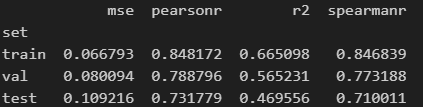

In [55]:
# 320 data points
!python /home/oscar/projects/strucbio_projects/plm_md_modeling/metl/metl/code/train_target_model.py @finetune_h1_af3_global.txt --enable_progress_bar true --enable_simple_progress_messages --uuid d1280_exp_bs32_esp25_wd100

/home/oscar/miniconda3/envs/metl/lib/python3.9/site-packages/pytorch_lightning/utilities/imports.py:22: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
Random seed not specified, using: 209772873
Global seed set to 209772873
User gave model UUID: d1280_exp_bs32_esp25_wd100
Did not find existing log directory corresponding to given UUID: d1280_exp_bs32_esp25_wd100
Created log directory: output/training_logs/d1280_exp_bs32_esp25_wd100
Final UUID: d1280_exp_bs32_esp25_wd100
Final log directory: output/training_logs/d1280_exp_bs32_esp25_wd100
/home/oscar/projects/strucbio_projects/plm_md_modeling/metl/metl/code/train_target_model.py:136: UserWarning: Using epoch-based backbone finetuning with early stopping enabled. It is possible early stopping triggers before the backbone is

# Additional recommendations

## Model selection

Selecting the model from the epoch with the lowest validation set loss can help prevent overfitting. It requires having a big enough validation set that provides an accurate estimate of performance. 

We enabled model selection if the validation set size was ≥ 32 for METL-Local and ≥ 128 for METL-Global. We found the optimization was more stable for METL-Local than METL-Global, thus smaller validation sets were still reliable. 

Enable model selection by setting argument `--ckpt_monitor val`.


## Backbone cutoff for METL-Global
Finetuning METL-Global is largely the same as METL-Local, except we recommend using a different threshold for model selection (see above), as well as a different backbone cutoff.

For METL-Local, we set `--backbone_cutoff -1`, which attaches the new prediction head immediately after the final fully connected layer. 

For METL-Global, we recommend setting `--backbone_cutoff -2`, which attaches the new prediction head immediately after the global pooling layer. We found this resulted in better finetuning performance for METL-Global.

# Running inference using finetuned model

We provide two ways to run inference: using our PyTorch Lightning-based inference framework or using your own inference loop. The example below shows you would use your own inference loop. See the [inference.ipynb](inference.ipynb) notebook for additional information. 

In [6]:
import torch

import inference
import encode as enc
import utils  # for loading dataset metadata

In [9]:
# the Lightning checkpoint from the finetuning we performed above
ckpt_fn = "output/training_logs/inqx2jYi/checkpoints/epoch=49-step=50.ckpt"
model = inference.load_pytorch_module(ckpt_fn)

/Users/sg/PycharmProjects/metl/code/inference.py:159: UserWarning: Transforming checkpoint keys: strip_prefix='model.', add_prefix=''
  warnings.warn(


In [10]:
# load the GFP wild-type sequence and the PDB file (needed for 3D RPE)
datasets = utils.load_dataset_metadata()
wt = datasets["avgfp"]["wt_aa"]
wt_offset = datasets["avgfp"]["wt_ofs"]
pdb_fn = datasets["avgfp"]["pdb_fn"]

# some example GFP variants to compute the scores for
variants = ["E3K,G102S",
            "T36P,S203T,K207R",
            "V10A,D19G,F25S,E113V"]

# encode the variants into the integer sequences format
# to feed into the model
encoded_variants = enc.encode(
    encoding="int_seqs",
    variants=variants,
    wt_aa=wt,
    wt_offset=wt_offset,
    indexing="0_indexed"
)

# set model to eval mode
model.eval()

# no need to compute gradients for inference
with torch.no_grad():
    # note we are specifying the pdb_fn because this model uses 3D RPE
    predictions = model(torch.tensor(encoded_variants), pdb_fn=pdb_fn)

print(predictions)

tensor([[-0.3805],
        [-0.3623],
        [-0.2217]])
